In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *

%matplotlib inline

**L'idée est d'explorer la survenue des spindle sur la respi, sur les cycles respi non stretchés, et donc de vraiment explorer quand se situent préférentiellement les spindle par rapport à des évènements respiratoires particuliers tels que la transition i vers e ou e vers i**

**Il faut donc découper les TF autour de ces évènements particuliers, avec une fenêtre qui entoure ces évènements .. à définir**

**Il faut donc :**
- Charger les rsp_features pour avoir les moments des transitions
- Charger les TF
- Fenêtrer les TF autour des transitions

In [28]:
mode = 'load'

## DATA LOADING

In [29]:
def load_rsp(patients=patients):
    concat = []
    for patient in patients:
        rsp = pd.read_excel(f'../df_analyse/resp_features_encoded_{patient}.xlsx', index_col = 0).loc[:,['patient', 'inspi_time','expi_time', 'cycle_duration','insp_duration','exp_duration','spindling code']]
        concat.append(rsp)
    df_return = pd.concat(concat)
    return df_return

In [30]:
rsp = load_rsp()

In [31]:
rsp

,patient,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,spindling code
0,P1,0.414062,1.507812,3.480469,1.093750,2.386719,0
1,P1,3.894531,4.921875,2.941406,1.027344,1.914062,0
2,P1,6.835938,7.953125,2.921875,1.117188,1.804688,0
3,P1,9.757812,10.875000,2.847656,1.117188,1.730469,0
4,P1,12.605469,13.660156,2.710938,1.054688,1.656250,0
...,...,...,...,...,...,...,...
1684,P10,7085.667969,7086.929688,2.914062,1.261719,1.652344,0
1685,P10,7088.582031,7089.804688,3.496094,1.222656,2.273438,0
1686,P10,7092.078125,7093.359375,3.144531,1.281250,1.863281,0
1687,P10,7095.222656,7096.410156,3.453125,1.187500,2.265625,0


In [32]:
half_window_size = round(rsp['exp_duration'].quantile(0.75), 1) # les fenetres comprendront la majorité du cycle respi
half_wsize_points = int(half_window_size * srate)

In [33]:
def load_tf(patients=patients):
    concat = []
    for patient in patients:
        print(patient)
        tf = xr.load_dataarray(f'../dataarray/da_tf_frontal_{patient}.nc')
        concat.append(tf)
    da_return = xr.concat(concat, dim = 'patient')
    da_return = da_return.assign_coords({'patient':patients})
    return da_return

In [34]:
if mode == 'save':
    da = load_tf()
elif mode == 'load':
    da = xr.load_dataarray(f'../dataarray/da_tf_frontal_all.nc')

In [35]:
da

<xarray.DataArray (patient: 10, normalisation: 2, freqs: 40, time: 1251840)>
array([[[[3.29539648e+04, 3.28151914e+04, 3.25098613e+04, ...,
                     nan,            nan,            nan],
         [2.91525605e+04, 2.89298086e+04, 2.85573262e+04, ...,
                     nan,            nan,            nan],
         [2.62262812e+04, 2.59618223e+04, 2.55622676e+04, ...,
                     nan,            nan,            nan],
         ...,
         [8.76728418e+03, 8.74045410e+03, 8.67086621e+03, ...,
                     nan,            nan,            nan],
         [8.76634082e+03, 8.75618945e+03, 8.70441016e+03, ...,
                     nan,            nan,            nan],
         [8.76778320e+03, 8.77137598e+03, 8.73402637e+03, ...,
                     nan,            nan,            nan]],

        [[2.19244266e+00, 2.18167830e+00, 2.15799451e+00, ...,
                     nan,            nan,            nan],
         [1.89757466e+00, 1.88029599e+00, 1.85140336e+00, ...,
                     nan,            nan,            nan],
         [1.67058825e+00, 1.65007484e+00, 1.61908209e+00, ...,
                     nan,            nan,            nan],
...
                     nan,            nan,            nan],
         [8.58875293e+03, 8.61773047e+03, 8.60715820e+03, ...,
                     nan,            nan,            nan],
         [8.45978906e+03, 8.49211914e+03, 8.48572559e+03, ...,
                     nan,            nan,            nan]],

        [[3.86462498e+00, 3.87458396e+00, 3.86398411e+00, ...,
                     nan,            nan,            nan],
         [3.64785719e+00, 3.65766883e+00, 3.64804983e+00, ...,
                     nan,            nan,            nan],
         [3.44247484e+00, 3.45239449e+00, 3.44398904e+00, ...,
                     nan,            nan,            nan],
         ...,
         [8.34292352e-01, 8.37542176e-01, 8.35048139e-01, ...,
                     nan,            nan,            nan],
         [8.20526361e-01, 8.24647427e-01, 8.23143899e-01, ...,
                     nan,            nan,            nan],
         [8.02185535e-01, 8.06783438e-01, 8.05874169e-01, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time           (time) float64 0.0 0.007812 0.01562 ... 9.78e+03 9.78e+03
  * freqs          (freqs) float64 10.0 10.26 10.51 10.77 ... 19.49 19.74 20.0
  * normalisation  (normalisation) object 'raw' 'normal'
  * patient        (patient) object 'P1' 'P2' 'P3' 'P4' ... 'P7' 'P8' 'P9' 'P10'

In [36]:
rsp[(rsp['patient'] == patient) & (rsp['spindling code'] == 1)].reset_index(drop=True)

,patient,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,spindling code
0,P1,15.316406,16.406250,2.644531,1.089844,1.554688,1
1,P1,27.113281,28.269531,3.117188,1.156250,1.960938,1
2,P1,30.230469,31.289062,3.003906,1.058594,1.945312,1
3,P1,33.234375,34.378906,3.093750,1.144531,1.949219,1
4,P1,36.328125,37.328125,2.875000,1.000000,1.875000,1
...,...,...,...,...,...,...,...
829,P1,6680.156250,6681.207031,3.050781,1.050781,2.000000,1
830,P1,6686.050781,6687.179688,5.011719,1.128906,3.882812,1
831,P1,6691.062500,6692.109375,3.285156,1.046875,2.238281,1
832,P1,6700.804688,6701.828125,2.664062,1.023438,1.640625,1


In [37]:
int(half_window_size*2) * 128

640

In [38]:
n_cycles_spindled = []
for patient in patients:
    n_cycles_spindled.append(rsp[(rsp['patient'] == patient) & (rsp['spindling code'] == 1)].reset_index(drop=True).shape[0])
min_n_cycles_spindled = min(n_cycles_spindled)


In [39]:
srate = 128

da_erp = None

for patient_idx, patient in enumerate(patients):
    print(patient)
    rsp_patient = rsp[(rsp['patient'] == patient) & (rsp['spindling code'] == 1)].reset_index(drop=True)
    # tf_erp = None
    da_patient = da.sel(patient = patient).dropna(dim = 'time')
    for transition_idx, transition in enumerate(['i-e','e-i']):
        
        if transition == 'i-e':
            timings = list(rsp_patient['expi_time'])
        elif transition == 'e-i':
            timings = list(rsp_patient['inspi_time'])
        
        for cycle, timing in enumerate(timings):
            if cycle == 295:
                break
            start_t = round(timing, 2) - half_window_size
            if start_t <= 0:
                continue
            stop_t = start_t + half_window_size*2

            
            wsize_in_points = int(half_wsize_points*2)
            # print(wsize_in_points)
            start_idx = int(start_t * srate)
            stop_idx = start_idx + wsize_in_points
            
            # tf_sliced = da.loc[patient, : , : , start_t:stop_t].reset_index('time').values

            tf_sliced = da_patient[ : , : , start_idx:stop_idx].values
            # print(tf_sliced.shape)
            
            if da_erp is None:
                # tf_erp = gh.init_da({'cycle':rsp_patient.index, 'transition':['i-e','e-i'], 'normalisation':da.coords['normalisation']  , 'freqs':da.coords['freqs'] , 'time':np.arange(start_t, stop_t, 1/srate)})
                da_erp = gh.init_da({'patient':patients, 'cycle':np.arange(0,min_n_cycles_spindled,1), 'transition':['i-e','e-i'], 'normalisation':da.coords['normalisation']  , 'freqs':da.coords['freqs'] , 'time':np.arange(0, wsize_in_points, 1)})
            
            da_erp[patient_idx, cycle , transition_idx , : , : , :] = tf_sliced
            
    # concat.append(tf_erp)

P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


In [40]:
da_erp = da_erp.assign_coords({'time':da_erp.coords['time']/srate})

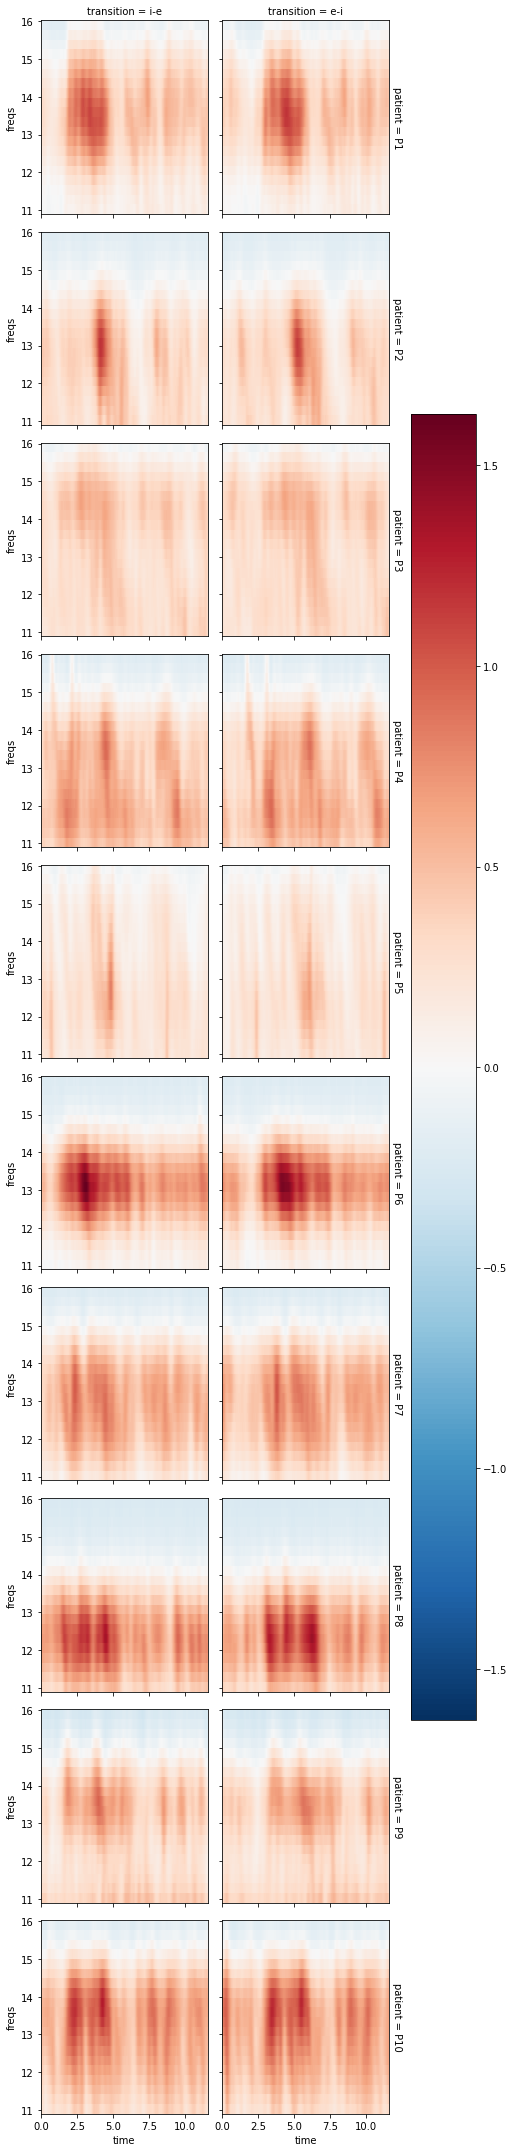

In [41]:
da_erp.mean('cycle').loc[:,:,'normal',11:16,:].plot.pcolormesh(x='time', col = 'transition', row ='patient')

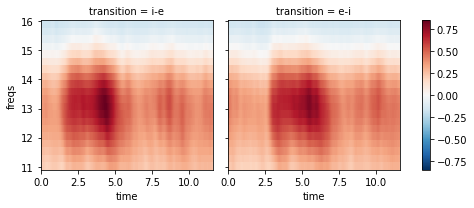

In [42]:
da_erp.mean(['patient','cycle']).loc[:,'normal',11:16,:].plot.pcolormesh(x='time', col = 'transition')

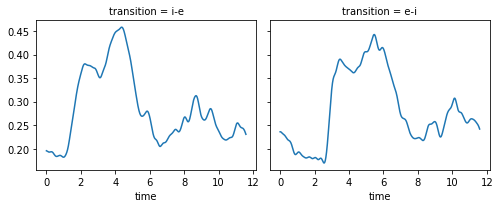

In [43]:
da_erp.mean(['patient','cycle']).loc[:,'normal',11:16,:].mean('freqs').plot.line(x='time', col = 'transition')

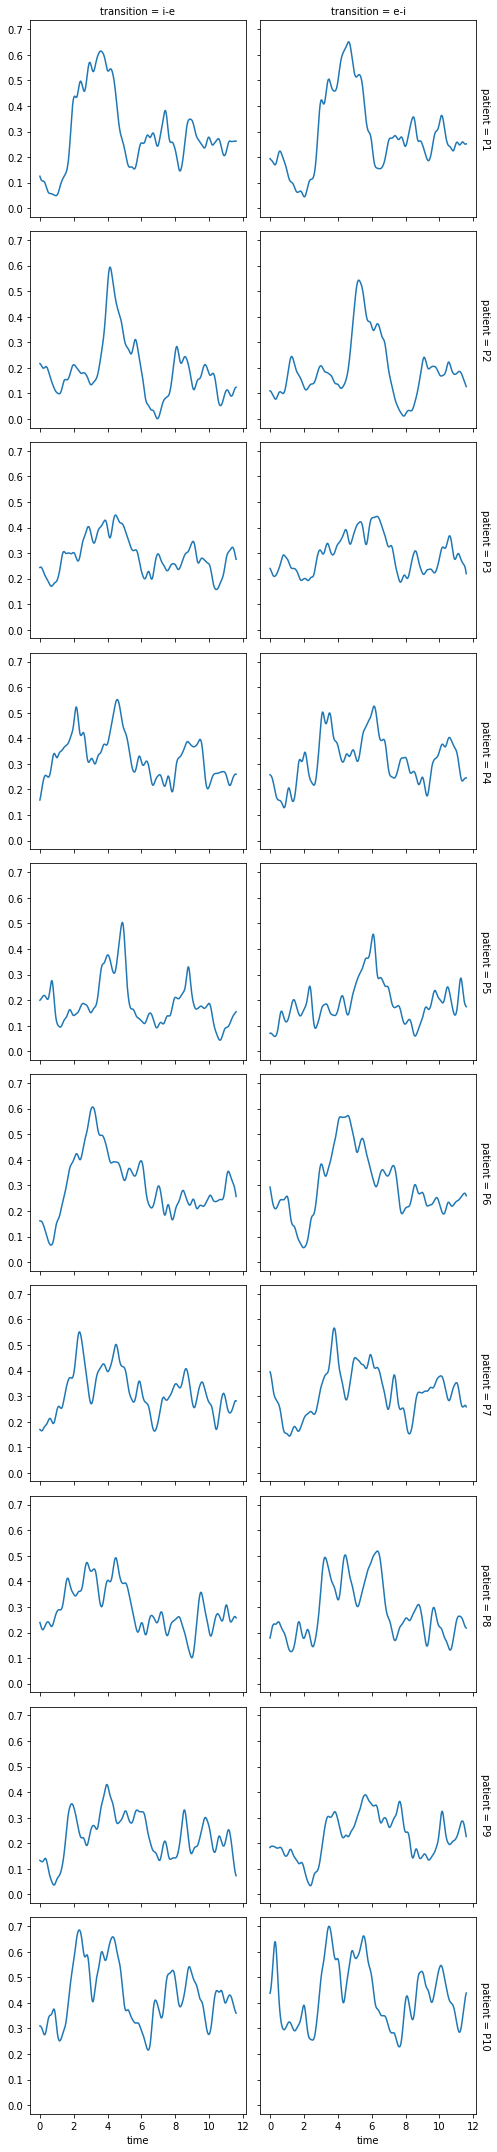

In [44]:
da_erp.mean(['cycle']).loc[:,:,'normal',11:16,:].mean('freqs').plot.line(x='time', col = 'transition', row = 'patient')

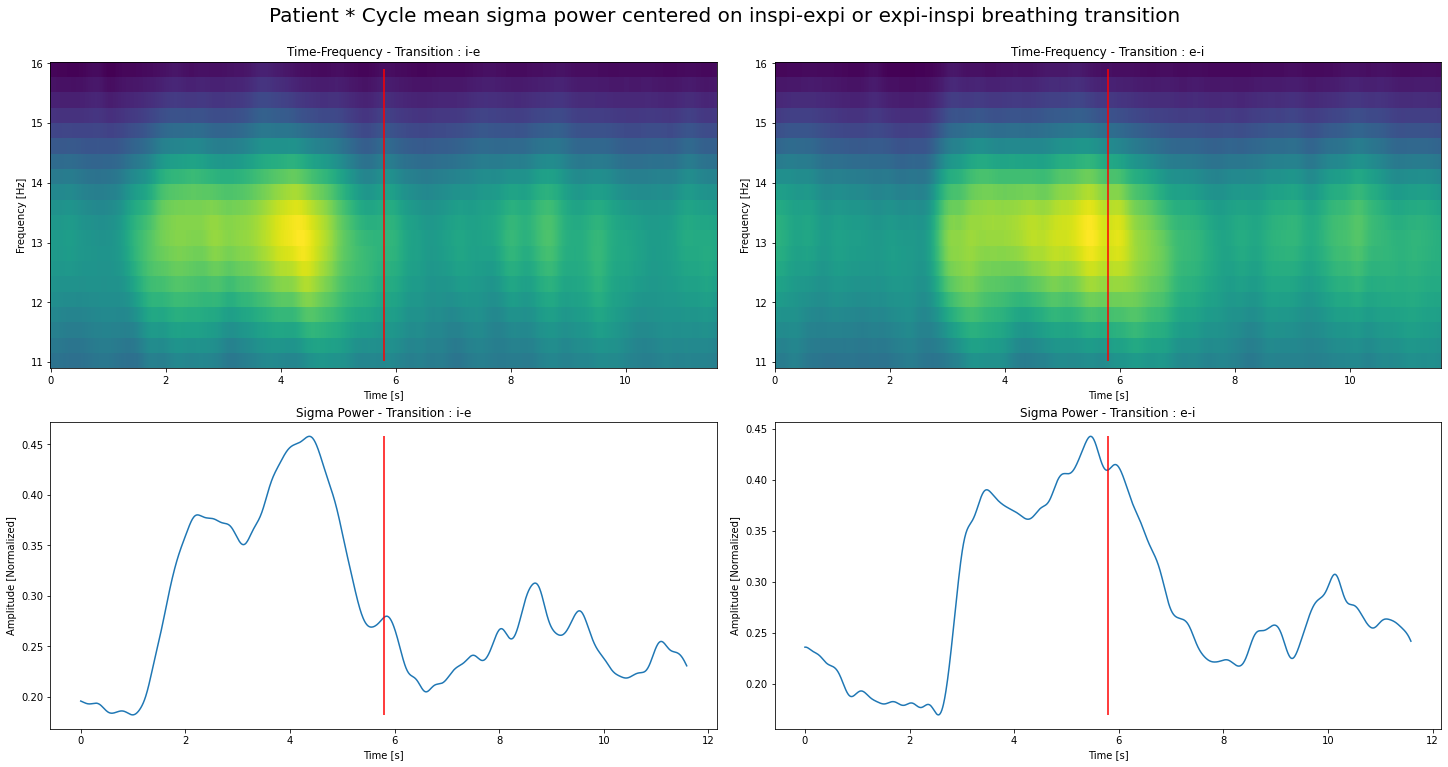

In [45]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10), constrained_layout = True)
fig.suptitle('Patient * Cycle mean sigma power centered on inspi-expi or expi-inspi breathing transition', fontsize = 20, y = 1.05)

da_to_plot = da_erp.mean(['patient','cycle']).loc[:,'normal',11:16,:]

for row, plot_mode in enumerate(['colormesh', 'line']):
    for col, transition in enumerate(da_to_plot.coords['transition'].values):

        ax = axs[row, col]
        t = da_to_plot.coords['time'].values
        f = da_to_plot.coords['freqs'].values
        data = da_to_plot.loc[transition,:].values

        if plot_mode == 'colormesh':
            ax.pcolormesh(t,f, data)
            ax.vlines(x=t[-1] / 2, ymin = min(f), ymax = max(f), color = 'r')
            ax.set_ylabel('Frequency [Hz]')
            ax.set_title(f'Time-Frequency - Transition : {transition}')

        elif plot_mode == 'line':
            ax.plot(t, np.mean(data, axis = 0))
            ax.vlines(x=t[-1] / 2, ymin = min(np.mean(data, axis = 0)), ymax = max(np.mean(data, axis = 0)), color = 'r')
            ax.set_ylabel('Amplitude [Normalized]')
            ax.set_title(f'Sigma Power - Transition : {transition}')

        ax.set_xlabel('Time [s]')
        
# plt.savefig('../presentation_3/erp_transition', bbox_inches = 'tight')

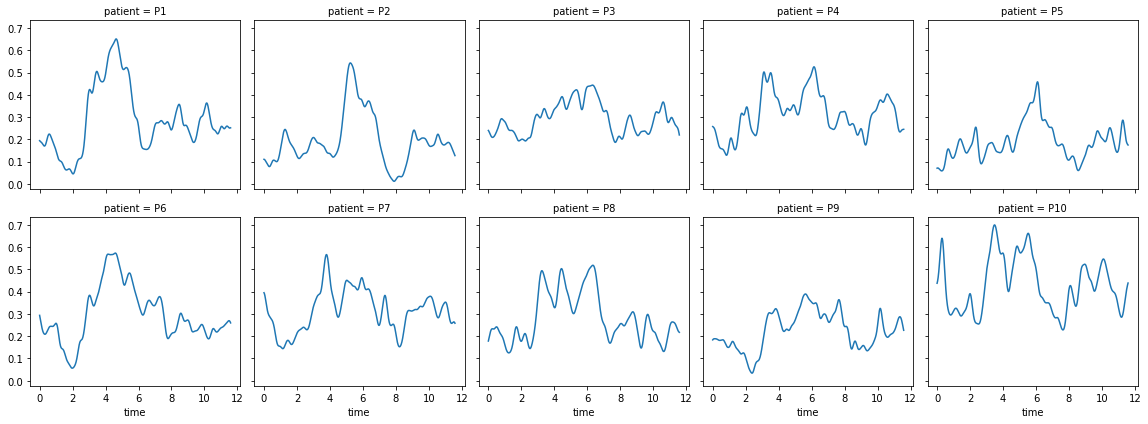

In [46]:
da_erp.mean(['cycle']).loc[:,'e-i','normal',11:16,:].mean('freqs').plot.line(x='time', col = 'patient', col_wrap = 5)
# plt.savefig('../presentation_3/erp_sigma_linepower_patients')

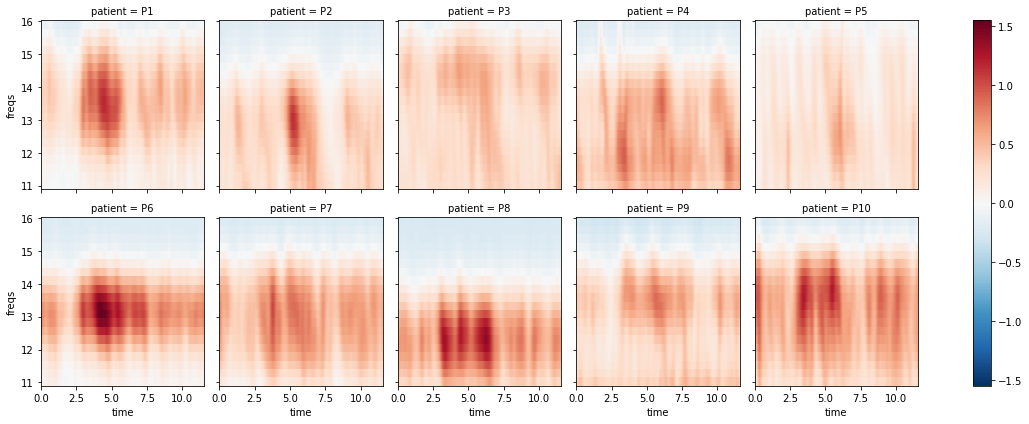

In [47]:
da_erp.mean(['cycle']).loc[:,'e-i','normal',11:16,:].plot.pcolormesh(x='time', col = 'patient', col_wrap = 5)
# plt.savefig('../presentation_3/erp_sigma_tf_patients')

In [49]:
rsp.mean()

/tmp/ipykernel_3342827/3410242324.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rsp.mean()


inspi_time        3906.047970
expi_time         3907.442376
cycle_duration       3.908787
insp_duration        1.394406
exp_duration         2.514381
spindling code       0.421047
dtype: float64